# Exercise 2: Our first classifier.


## I. GOAL OF THE EXERCISE

In this exercise you will practice the basic pipeline of the supervised learning task. Implement a simple classifier. And will try to solve several hinderances found in the process.

## II. DELIVERABLES
As you progress in this exercise, you will find several questions you are expected to answer them properly with adequate figures when required and deliver the notebook with the working code used for generating and discussing the results in due time.


<div class = "alert alert-danger" style="border-radius:10px"> **IMPORTANT:** Write in the next cell the name of the people that answer this notebook
</div>

## Your names

## III. OUR FIST CLASSIFIER.
We are given the data in diabetes.mat and our goal is to predict the whether a person suffers from diabetes or not given her medical record. Our first model to try is linear regression as explained in ”A gentle introduction to supervised learning”.

### A. Understanding and preprocessing our problem.
The first step in the learning pipeline is to have a general picture of your dataset particularities.

### B. Data set analysis
Load the dataset and describe the basic properties of the data,

<div class = "alert alert-success" style = "border-radius:10px">**QUESTION BLOCK 1:**
<ol>
<li> Which is the cardinality (number of examples) of the training set?</li> 
<li> Which is the dimensionality of the training set? </li>
<li> Which is the mean value of the training set? </li>
</ol>
<div>

In [92]:
import scipy.io as sio
import numpy as np
data = sio.loadmat('diabetes.mat')

X = data['x'].T
y = data['y']

In [93]:
#Your code here
print "The number of examples is", X.shape[0]
print "The number of dimensions of the training set is", X.shape[1],"\n"

print "The mean value for each dimension of the training set is:\n",np.nanmean(X, axis=0)
print "The mean value of the labels of training set is: ", np.mean(y)

The number of examples is 768
The number of dimensions of the training set is 8 

The mean value for each dimension of the training set is:
[   4.49467275  121.68676278   72.40518417   29.15341959  155.54822335
   32.45746367    0.4718763    33.24088542]
The mean value of the labels of training set is:  -0.302083333333


As you can see there are some missing values with value NaN and som
e categorical data.

<div class = "alert alert-success" style = "border-radius:10px">**QUESTION BLOCK 2:**
<ol>
<li> Create a new dataset D1, replacing the NaN values with the mean value of the corresponding attribute without considering the missing values. </li>
<li> Create a new dataset D2, replacing the NaN values with the mean value of the corresponding attribute without considering the missing values conditioned to the class they belong, i.e. replace the missing attribute values of class +1 with the mean of that attribute of the examples of class +1, and the same for the other class. </li>
<li> **[Optional :]** Explain another method to deal with missing values and apply it to preprocess the training data. Include the reference of the method used. Consider this new dataset as D3. </li>
<li> Which are the new mean values of each dataset?</li>
</ol>
</div>

In [94]:
# 2 - 1
def getD1(X,y,mean=None):
    if mean is None:
        # We have to compute it
        mean = np.nanmean(X, axis=0)
    D1=np.array(X)
    for i in range(X.shape[1]):
        D1[:,i][np.isnan(D1[:,i])]=mean[i]
    return D1
# 2 - 2
def getD2(X,y):
    D2=np.array(X)
    for i in range(X.shape[1]):
        # We are using references so that we dont have to copy anything
        D2Col = np.asmatrix(D2[:,i]).T
        meanC1 = np.nanmean(D2Col[y==1])
        meanC2 = np.nanmean(D2Col[y==-1])
        D2Col[np.logical_and(np.isnan(D2Col), y == 1)] = meanC1
        D2Col[np.logical_and(np.isnan(D2Col), y == -1)] = meanC2
    return D2

# 2 - 3
# We can, for example use the median or the most frequent value instead of the average
# Another option is to use something similar to KNN, we get the closest examples and use the mean value
# of the closest examples ()

from collections import Counter
def getD2Ext(X, y, strategy="mean"):
    D2=np.array(X)
    for i in range(X.shape[1]):
        # We are using references so that we dont have to copy anything
        D2Col = np.asmatrix(D2[:,i]).T
        estC1=0
        estC2=0
        if (strategy == "mean"):
            estC1 = np.nanmean(D2Col[y==1])
            estC2 = np.nanmean(D2Col[y==-1])
        elif (strategy == "median"):
            estC1 = np.nanmedian(np.asarray(D2Col[y==1]))
            estC2 = np.nanmedian(np.asarray(D2Col[y==-1]))
        elif (strategy == "most_frequent"):
            estC1 = Counter(np.asarray(D2Col[y==1]).flatten()).most_common(1)[0][1]
            estC2 = Counter(np.asarray(D2Col[y==-1]).flatten()).most_common(1)[0][1]
        else:
            raise Exception('Invalid strategy = '+strategy)
        D2Col[np.logical_and(np.isnan(D2Col), y == 1)] = estC1
        D2Col[np.logical_and(np.isnan(D2Col), y == -1)] = estC2
    return D2

from scipy import spatial
def getD3(X,y,K=5,minDistanceDifferentClass=10000):
    D3=np.array(X)
    # In order to have an euclidean space, we have to find neighbours into an
    # space with no nans, this is why we need to use one of the previously defined
    # nan removal algorithms.
    # This could be avoided using other mechanisms, but its implementation would take
    # longer, so we exclude it from this exercise
    Xnn = getD2Ext(X,y)
    if minDistanceDifferentClass > 0:
        # We add a last coordinate so that examples from different classes will very faraway
        Xnn = np.concatenate((Xnn, (minDistanceDifferentClass/2)*y), axis=1)
    for j in range (X.shape[1]):
        # We get the matrix removing the target column
        auxXnn = Xnn[:,[x for x in range(Xnn.shape[1]) if x != j]]
        Tree = spatial.cKDTree(auxXnn, leafsize=100)
        for i in range(X.shape[0]):
            if np.isnan(D3[i,j]):
                # Has a NAN value, we have to find the nearest
                vnn=auxXnn[i]
                # We have to add one to K, because the nearest neighbour is always the actual point
                # and it is always nan, so it won't affect the result
                nearest = Tree.query(vnn, k=(K+1))
                meanNearest = np.nanmean(D3[nearest[1], j])
                if np.isnan(meanNearest):
                    # If all nearest neighbours are NaN, we can use the average calculated with
                    # the other algorithms
                    D3[i,j]=Xnn[i,j]
                else:
                    D3[i,j]=meanNearest
    return D3

# 2 - 4

D1=getD1(X,y)
D2=getD2(X,y)
D2Ext=getD2Ext(X,y, strategy="median")
D3=getD3(X,y)


meanD1 = np.mean(D1, axis=0)
meanD2 = np.mean(D2, axis=0)
meanD2Ext = np.mean(D2Ext, axis=0)
meanD3 = np.mean(D3, axis=0)

print 'For D1, the mean we get is:', meanD1
print 'For D2, the mean we get is:', meanD2
print 'For D2 using median, the mean we get is:', meanD2Ext
print 'For D3 (Nearest), the mean we get is:', meanD3      


For D1, the mean we get is: [   4.49467275  121.68676278   72.40518417   29.15341959  155.54822335
   32.45746367    0.4718763    33.24088542]
For D2, the mean we get is: [   4.49265212  121.69735767   72.42814101   29.24704236  157.00352686
   32.44642005    0.4718763    33.24088542]
For D2 using median, the mean we get is: [   4.37760417  121.67708333   72.38932292   29.08984375  141.75390625
   32.43463542    0.4718763    33.24088542]
For D3 (Nearest), the mean we get is: [   4.41643663  121.63463542   72.40717593   29.10808412  152.62999553
   32.40554687    0.4718763    33.24088542]


### C. A simple classifier

Our first classifier is a thresholded regressor. Use and/or modify any of the methods you implemented for regression and apply it to find a linear classifier.

<div class = "alert alert-success" style = "border-radius:10px">**QUESTION BLOCK 3:**
<ol>
<li>In this model you have to learn the threshold value. Explain how you can accommodate this parameter.</li>
<li>Report the normal vector of the separating hyperplane for each data set D1, D2, D3.</li>
<li>Compute the error rates achieved on the training data. Are there significant differences? Report the method used and their parameters.</li>
</ol>
<div>

In [95]:
# This classifier consists in a function that maps each point to a certain value and a threshold
# value. All points above that threshold are considered as elements of one class and the ones
# bellow are considered as elements of the other.
# This is:
# For each point X, if sum(wi*xi) [i=1 to d] > threshold, X is of class 1. Otherwise X is of class -1.

# In order to apply a regressor to this equation, if consider that all examples of class 1 have
# a value of SCALE and the ones of class -1 -SCALE, we can clearly find the two components:
# The weights of a linear regessor are: W=wn, ...,w1,w0
# And as we said, the regressor has the form h(x) =  sign( sum(wi*xi) [i=0 to d] - threshold )
# If we use the regressor weights in the previous function: h(x) = sign(W·X - (treshold+w0))
# As such, we see that if we change the regressor's w0 to w0'=(w0+threshold), by changing w0'
# we can change the threshold of the regressor.

# This is the analytic regression solver copied from the first practice
# We try to minimize the error of the regression as if the expected output was a continous function
# For this reason, in this case the MSE error will always be greater than 0
def analyticSolve(x, y, threshold=0, scale=1):
    y = np.dot(scale,y)
    w = np.zeros((x.shape[1]+1,1))
    xWave = np.concatenate((x, np.ones((x.shape[0],1))), axis=1)
    w = np.linalg.inv(xWave.T.dot(xWave)).dot(xWave.T).dot(y)
    if threshold != 0:
        w[w.shape[1]-1,0] = w[w.shape[1]-1,0]+threshold
    return w

def computeErrors(x, y, w):
    TP=0
    FP=0
    TN=0
    FN=0
    xWave = np.concatenate((x, np.ones((x.shape[0],1))), axis=1)
    for i in range(x.shape[0]):
        calculated = np.dot(np.matrix(xWave[i]), w)
        if calculated > 0:
            if y[i] == 1:
                TP=TP+1
            else:
                FP=FP+1
        else:
            if y[i] == 1:
                FN=FN+1
            else:
                TN=TN+1
    return [[TP, FN], [FP,TN]]

def printResults(w, pt, showWeights=False, showNormal=False):
    if showWeights:
        # This defines the plane (wn*xn + ... + w1*x1 + w0 = 0)
        print "The obtained weights are:",w
    if showNormal:
        # The last coordinate of the weights (w0), is defined from one of the points in the plane
        # (w0 = -(wn*xn0 + ... + w1*x10)) where xn0,...,x10 is a point
        # The rest of the coordinates (wn,...,w1) defines the normal vector
        print "The normal vector is: ", w[0:w.shape[0]-1] 
    
    accuracy=(pt[0][0]+pt[1][1])/float(pt[0][0]+pt[0][1]+pt[1][0]+pt[1][1])
    precission=0
    recall=0
    npv=0
    tnr=0
    if pt[0][0]+pt[1][0] > 0:
        precission = pt[0][0]/float(pt[0][0]+pt[1][0])
        recall =pt[0][0]/float(pt[0][0]+pt[0][1])
    if pt[1][1]+pt[0][1] > 0:
        npv=pt[1][1]/float(pt[1][1]+pt[0][1])
    if pt[1][1]+pt[1][0] > 0:
        tnr=pt[1][1]/float(pt[1][1]+pt[1][0])
    print "Accuracy:", accuracy, "(Error Rate:",(1-accuracy)*100,"%)"
    print "Precission (PPV): ", precission;
    print "Recall (TPR): ", recall;
    print "NPV: ", npv
    print "TNR: ", tnr


xWave = np.concatenate((D1, np.ones((D1.shape[0],1))), axis=1)
w = analyticSolve(D1, y)
table = computeErrors(D1,y,w)
print "For D1:"
printResults(w,table,showNormal=True);
print "\n"

w = analyticSolve(D2, y)
table = computeErrors(D2,y,w)
print "For D2:"
printResults(w,table, showNormal=True);
print "\n"

w = analyticSolve(D3, y)
table = computeErrors(D3,y,w)
print "For D3:"
printResults(w,table,showNormal=True);
print "\n"

For D1:
The normal vector is:  [[  4.54830899e-02]
 [  1.28752133e-02]
 [ -2.76153057e-03]
 [  3.09178172e-04]
 [ -1.75410884e-04]
 [  2.73791130e-02]
 [  2.50953772e-01]
 [  4.98452234e-03]]
Accuracy: 0.778645833333 (Error Rate: 22.1354166667 %)
Precission (PPV):  0.73786407767
Recall (TPR):  0.567164179104
NPV:  0.79359430605
TNR:  0.892


For D2:
The normal vector is:  [[ 0.0556913 ]
 [ 0.00988663]
 [-0.00151083]
 [ 0.01041739]
 [ 0.00186537]
 [ 0.0160551 ]
 [ 0.22947897]
 [ 0.00183327]]
Accuracy: 0.798177083333 (Error Rate: 20.1822916667 %)
Precission (PPV):  0.755656108597
Recall (TPR):  0.623134328358
NPV:  0.815356489945
TNR:  0.892


For D3:
The normal vector is:  [[ 0.05251374]
 [ 0.01151445]
 [-0.00310255]
 [ 0.00428877]
 [ 0.00061375]
 [ 0.02273705]
 [ 0.23253102]
 [ 0.0029058 ]]
Accuracy: 0.772135416667 (Error Rate: 22.7864583333 %)
Precission (PPV):  0.718309859155
Recall (TPR):  0.570895522388
NPV:  0.792792792793
TNR:  0.88




Training error is a poor estimation of the generalization error. Let us test what happens in a test set created by holding-out a certain percentage of the original dataset.

<div class = "alert alert-success" style = "border-radius:10px">**QUESTION BLOCK 4:**

Repeat the learning process in block 3 using just D2 but holding-out the last fifth of the data set for testing purposes, i.e. use the first 4/5-th for training and the last 1/5-th for testing. Follow exactly the following steps in your process:
<ol>
<li> Clear your workspace: `%reset -f` at the begining of the cell. </li>
<li> Preprocess the data replacing the NaN using the method for creating D2.</li>
<li> Split your data in two sets: the first 4/5-th is to be used for training and
the last 1/5-th will be used for testing purposes. Use a random seed value equal to 42.</li>
<li> Train your model on the training set.</li>
<li> Answer the following questions: Which is the error rate on your training
data? Which is the error rate on your test data? Are they similar? Did you expect that behavior? Why?</li>
</ol>
</div>

In [96]:
# 4 - 1
# %reset -f

# 4 - 2
D2=getD2(X,y)
D2y=np.array(y)

# 4 - 3
# Set the seed
np.random.seed(42)
# Shuffle the dataset
indices = np.random.permutation(D2.shape[0])
# Create the corpuses
numTrainingExamples = int(0.8*D2.shape[0])
TrD2x, TeD2x = D2[indices[:numTrainingExamples]], D2[indices[numTrainingExamples:]]
TrD2y, TeD2y = D2y[indices[:numTrainingExamples]], D2y[indices[numTrainingExamples:]]

# 4 - 4
w = analyticSolve(TrD2x, TrD2y)

# 4 - 5
print "Training:"
tableTraining = computeErrors(TrD2x,TrD2y,w)
print tableTraining
printResults(w,tableTraining);
print "-------------------------------"
print "Test:"
tableTraining = computeErrors(TeD2x,TeD2y,w)
print tableTraining
printResults(w,tableTraining);

# As we can see, there is a difference in the accuracy value obtained in the
# training set and in the test set. This is to be expected as the classifier is optimized for the
# examples in the training set, and hence the accuracy is better when checking that set.


Training:
[[131, 79], [40, 364]]
Accuracy: 0.806188925081 (Error Rate: 19.3811074919 %)
Precission (PPV):  0.766081871345
Recall (TPR):  0.62380952381
NPV:  0.821670428894
TNR:  0.90099009901
-------------------------------
Test:
[[32, 26], [10, 86]]
Accuracy: 0.766233766234 (Error Rate: 23.3766233766 %)
Precission (PPV):  0.761904761905
Recall (TPR):  0.551724137931
NPV:  0.767857142857
TNR:  0.895833333333


<div class = "alert alert-success" style = "border-radius:10px"> **QUESTION BLOCK 5:**
Repeat the process in block 4 changing the order of some of the steps. Follow exactly the following steps in your process:
<ol>
<li> Clear your workspace with `%reset -f`.</li>
<li> Split your data in two sets: the first 4/5-th is to be used for training and the last 1/5-th will be used for testing purposes. Use random state or random seed value of 42. </li>
<li> Preprocess the data replacing the NaN using the method for creating D2. But this time use only the data corresponding to the training set. </li>
<li> Train your model on the training set.</li>
<li> Replace the NaN values using the means computed on the training data. </li>
<li> Answer the following questions: Which is the error rate on your training data? Which is the error rate on your test data? Are they similar? Did you expect that behavior? Why? </li>
<li> Compare these results with the ones in block 4. Do we achieve better or worse results? Why?</li>
<div>

In [97]:
# I am defining this exercise as a block in order to be able to use it in the last exercise
def block5(X,y, trainingRatio=0.8):
    # 5 - 1
    # %reset -f

    # 5 - 2
    # Set the seed
    np.random.seed(42)
    # Shuffle the dataset
    indices = np.random.permutation(X.shape[0])
    # Create the corpuses
    numTrainingExamples = int(trainingRatio*X.shape[0])
    Trx, Tex = X[indices[:numTrainingExamples]], X[indices[numTrainingExamples:]]
    Try, Tey = y[indices[:numTrainingExamples]], y[indices[numTrainingExamples:]]

    # 5 - 3
    TrD2x=getD2(Trx,Try)

    # 5 - 4
    w = analyticSolve(TrD2x, Try)

    # 5 - 5
    TrMean = np.nanmean(Trx, axis=0)
    TeD1x = getD1(Tex,Tey,TrMean)
    
    return [w, TrD2x, Try, TeD1x, Tey]

w, TrD2x, Try, TeD1x, Tey = block5(X,y);

# 5 - 6
print "Training:"
TrTable = computeErrors(TrD2x,Try,w)
printResults(w,TrTable);
print "-------------------------------"
print "Test:"
TeTable = computeErrors(TeD1x,Tey,w)
printResults(w,TeTable);

# Just like in the previous exercise, there is a considerable difference between the two corpuses.
# In this case it is even greater. This is because he mechanism to remove NaNs in the previous exercise 
# was done taking into consideration the values and points of the test set. This is certainly odd, because
# in a real case scenario we cannot replace NaN values depending on the value that we want to infer (D2 uses the class).
# For this reason, in the previous exercise the training set and test set were more similar and more correlated than
# in this second exercise.


Training:
Accuracy: 0.804560260586 (Error Rate: 19.5439739414 %)
Precission (PPV):  0.761627906977
Recall (TPR):  0.62380952381
NPV:  0.821266968326
TNR:  0.898514851485
-------------------------------
Test:
Accuracy: 0.746753246753 (Error Rate: 25.3246753247 %)
Precission (PPV):  0.74358974359
Recall (TPR):  0.5
NPV:  0.747826086957
TNR:  0.895833333333


<div class = "alert alert-success" style = "border-radius:10px"> **QUESTION BLOCK 6:**
<ol>
<li> Repeat the process in block 5 changing the percentage of the data for training and testing. Plot a graph with the training and test error rates for each splitting percentage point. Comment the results.</li>
<li> Add to the plot the upper bound on the generalization error using the equation of the slides for VC dimension equal to $d + 1$. Discuss the result.</li>
<li> How many samples does the bound predict in order to have 1% error deviation with a confidence of 95%? And with confidence 50%? What about 5% and 10% error deviation with 95% confidence? Comment the behavior according to your observations.</li>
</ol>
<div>

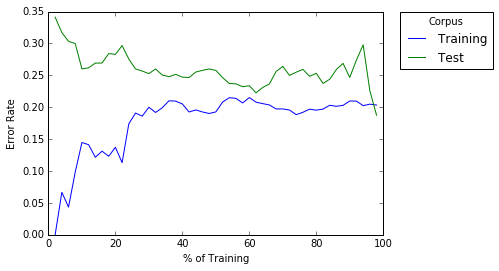

In [98]:
TrErrors=[]
TeErrors=[]
TrPcts=[]
for i in range(2,100,2):
    w, TrD2x, Try, TeD1x, Tey = block5(X,y,i/float(100))
    tableTraining = computeErrors(TrD2x,Try,w)
    
    # Calculate error in training
    TrTable = computeErrors(TrD2x,Try,w)
    TrError=(TrTable[0][1]+TrTable[1][0])/float(TrTable[0][0]+TrTable[0][1]+TrTable[1][0]+TrTable[1][1])
    
    # Calculate error in Test
    TeTable = computeErrors(TeD1x,Tey,w)
    TeError=(TeTable[0][1]+TeTable[1][0])/float(TeTable[0][0]+TeTable[0][1]+TeTable[1][0]+TeTable[1][1])
    
    # Add to plots
    TrErrors.append(TrError)
    TeErrors.append(TeError)
    TrPcts.append(i)

    
import matplotlib.pyplot as plt

%matplotlib inline

plt.ylabel('Error Rate')
plt.xlabel('% of Training')
plt.hold('on')
plt.plot( TrPcts, TrErrors, label="Training")
plt.plot(TrPcts, TeErrors,  label="Test")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Corpus')

In [ ]:
# I DON'T KNOW HOW TO APPLY THE FORMULA